In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import time
import copy
import timm
import random
import warnings
import numpy as np
import pandas as pd
import datetime as dt
from PIL import Image
from ranger import Ranger
import matplotlib.image as mpi
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision
from torchvision import transforms, datasets, models
from albumentations import (GaussianBlur, Cutout, Rotate, SmallestMaxSize, CenterCrop, RGBShift, HorizontalFlip,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop, HueSaturationValue)
from albumentations.pytorch import ToTensor
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(43)

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c #competition 

100%|███████████████████████████████████████▉| 690M/691M [00:18<00:00, 38.4MB/s]
100%|████████████████████████████████████████| 691M/691M [00:18<00:00, 39.8MB/s]


In [4]:
!unzip -qq test_Bh8pGW3.zip
!rm -r test_Bh8pGW3.zip

In [5]:
!unzip -qq train_DETg9GD.zip
!rm -r train_DETg9GD.zip

In [6]:
device = torch.device("cuda")

In [7]:
class data(Dataset):
    def __init__(self,df,root,phase,transform=None):
        self.df = df
        self.root = root
        self.phase = phase
        self.ages = np.sort(self.df['Class'].unique())
        self.transform = transform
    
    def __len__(self):
        return len(self.df.index.tolist())
    
    def __getitem__(self,idx):
        if self.phase == 'train':
            img_name = join(self.root,str(self.df.iloc[idx,0]))
        else:
            img_name = join(self.root,str(self.df.iloc[idx,1]))
        img = plt.imread(img_name)
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        if self.phase == 'train':    
            label = np.where(self.ages==self.df.iloc[idx,1])[0][0]
            return img,label
        else: return img

In [8]:
labels = pd.read_csv('/notebooks/train.csv')

In [9]:
train_data = train_data = data(labels,'/notebooks/Train','train')

In [9]:
mean1 = [0,0,0]
count = 0
for i in range(len(train_data)):
    img = train_data[i][0]
    mean1 += img.sum(axis=(0,1))
    count += img.shape[0]*img.shape[1]
mean1 /= count
mean1 

array([113.48426831,  84.10375225,  73.53828673])

In [10]:
std1 = [0,0,0]
for i in range(len(train_data)):
    img = train_data[i][0]
    std1 += ((img-mean1)**2).sum(axis=(0,1))
std1 /= count
std1 = (std1)**(0.5)
std1

array([53.23780389, 44.81640992, 44.64989943])

In [11]:
mean1 /= 255
std1 /= 255
print(mean1,std1)

[0.44503635 0.32981864 0.28838544] [0.2087757  0.17575063 0.17509764]


In [10]:
normalize = Normalize(
   mean =  [0.485, 0.456, 0.406],
   std =  [0.229, 0.224, 0.225]
)
tr_trns = Compose([SmallestMaxSize(256),
               RandomCrop(256,256),
               #HorizontalFlip(),
               Cutout(),
               RGBShift(),
               #HueSaturationValue(),
               #GaussNoise(),
               #GaussianBlur(),
               RandomBrightnessContrast(),
               #Rotate(limit=(-90,90)),
               normalize,
               ToTensor()])
ts_trns = Compose([SmallestMaxSize(max_size=256),
               CenterCrop(256,256),
               normalize,
               ToTensor()])

In [49]:
class Trainer(object):
    
    def __init__(self,model,dataloader,num_epochs=20):
        self.model = model
        self.best_model = copy.deepcopy(self.model.state_dict())
        self.best_acc = 0.0
        self.dataset_sizes = {'train': len(dataloader['train'].dataset), 
                     'val': len(dataloader['val'].dataset)}
        self.dataloader = dataloader
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = Ranger(self.model.parameters(),lr = 0.0001, weight_decay = 0.01)
        self.scheduler = ReduceLROnPlateau(self.optimizer,factor=0.33, mode="min", patience=4)
        self.num_epochs = num_epochs
        self.phases = ["train", "val"]
        cudnn.benchmark = True
        self.acc = {phase: [] for phase in self.phases}
        self.loss = {phase: [] for phase in self.phases}
        self.f1 = {phase: [] for phase in self.phases}
        
    def train(self):
        for i in range(self.num_epochs):
            t = time.time()
            for phase in self.phases:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                run_loss = 0.0
                run_correct = 0
                f1s = []
                for x,y in self.dataloader[phase]:
                    x,y = x.to(device),y.to(device)
                    self.optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        scores = self.model(x)
                        _, y_pred = torch.max(scores, 1)
                        loss = self.criterion(scores,y)
                        f1 = f1_score(y.cpu(),y_pred.cpu(),average = 'weighted')
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()
                        f1s.append(f1)
                        run_loss += loss.data.item()*x.shape[0]
                        run_correct += torch.sum(y_pred == y).data.item()
                epoch_f1 = np.mean(f1s)        
                epoch_loss = run_loss / self.dataset_sizes[phase]
                epoch_acc = run_correct / self.dataset_sizes[phase]
                self.acc[phase].append(epoch_acc)
                self.loss[phase].append(epoch_loss)
                self.f1[phase].append(epoch_f1)
                if phase == 'val' and epoch_acc > self.best_acc:
                    self.best_acc = epoch_acc
                    self.best_model = copy.deepcopy(self.model.state_dict())
                    self.save('/notebooks/storage/best-checkpoint-{}epoch.bin'.format(str(i).zfill(3)),i)

            print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ''val loss: {:.4f} acc: {:.4f} ''time: {:.4f}'.format(
                    i+1, self.num_epochs,
                    self.loss['train'][i], self.acc['train'][i], 
                    self.loss['val'][i], self.acc['val'][i],(time.time()-t)))
    
        print('Best val Acc: {:4f}'.format(self.best_acc))

        self.model.load_state_dict(self.best_model)
        return self.model,self.loss,self.acc
    
    def save(self, path, epoch):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_acc': self.best_acc,
            'epoch': epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_acc = checkpoint['best_acc']
        

In [12]:
df = pd.read_csv('/notebooks/train.csv')
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [13]:
ages = np.sort(df['Class'].unique())
ages

array(['MIDDLE', 'OLD', 'YOUNG'], dtype=object)

In [14]:
tr_lab,val_lab = train_test_split(df,test_size=0.2)

In [15]:
train_data = data(tr_lab,'/notebooks/Train/','train',transform = tr_trns)
val_data = data(val_lab,'/notebooks/Train/','train',transform = ts_trns)

In [16]:
train_dl = DataLoader(train_data, batch_size=16, num_workers=0)
val_dl = DataLoader(val_data, batch_size=16, num_workers=0)

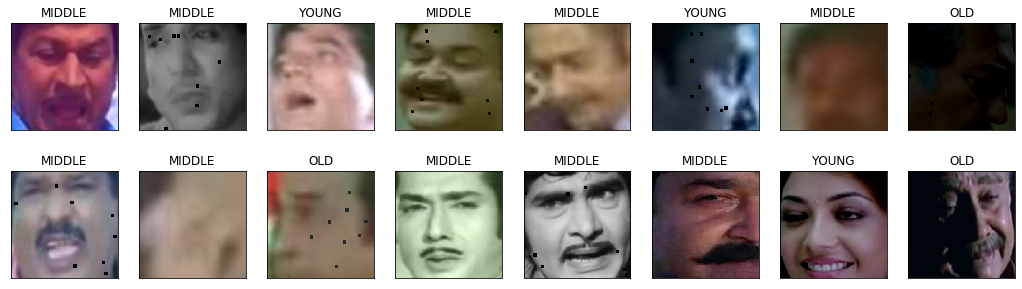

In [17]:
dataiter = iter(train_dl)
img,label = dataiter.next()
def im_show(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = img.numpy().transpose((1,2,0))*std + mean
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(npimg)
fig = plt.figure(figsize=(18,5))

for i in np.arange(16):
    ax = fig.add_subplot(2,8,i+1,xticks=[],yticks=[])
    im_show(img[i])
    ax.set_title(ages[label[i]])

In [25]:
resnet = models.resnet50(pretrained=True)

In [26]:
#for param in resnet.parameters():
#    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs,3)
resnet = resnet.to(device)

In [22]:
for p in resnet.parameters():
    p.requires_grad = True

340

In [18]:
#timm.model.efficientnet_b3
resnet = timm.create_model('efficientnet_b3', pretrained = True, num_classes = 3)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth


In [19]:
resnet = resnet.to(device)

In [50]:
dloaders = {'train':train_dl, 'val':val_dl}
trainer1 = Trainer(resnet,dloaders,10)

In [ ]:
model,loss,acc = trainer1.train()

Epoch [1/10] train loss: 0.0086 acc: 0.9974 val loss: 0.6397 acc: 0.8940 time: 344.6958
Epoch [2/10] train loss: 0.0033 acc: 0.9991 val loss: 0.6716 acc: 0.8943 time: 345.1041
Epoch [3/10] train loss: 0.0036 acc: 0.9987 val loss: 0.6832 acc: 0.8950 time: 343.7571
Epoch [4/10] train loss: 0.0035 acc: 0.9992 val loss: 0.6950 acc: 0.8985 time: 344.7746
Epoch [5/10] train loss: 0.0022 acc: 0.9993 val loss: 0.6990 acc: 0.8963 time: 343.3267
Epoch [6/10] train loss: 0.0015 acc: 0.9994 val loss: 0.7553 acc: 0.8968 time: 342.9840
Epoch [7/10] train loss: 0.0016 acc: 0.9996 val loss: 0.7851 acc: 0.8943 time: 341.8864
Epoch [8/10] train loss: 0.0007 acc: 0.9999 val loss: 0.8438 acc: 0.8968 time: 346.2801
Epoch [9/10] train loss: 0.0009 acc: 0.9996 val loss: 0.9041 acc: 0.8955 time: 342.4724


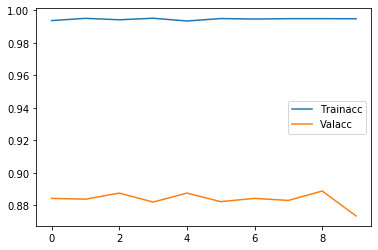

In [46]:
epoch = []
for x in range(10):
    epoch.append(x)
plt.plot(epoch,acc['train'],label = 'Trainacc')
plt.plot(epoch,acc['val'],label = 'Valacc')
plt.legend()
plt.show()

In [47]:
trainer1.load('/notebooks/storage/best-checkpoint-allepoch.bin')
resnet = trainer1.model

In [48]:
trainer1.optimizer.state_dict

<bound method Lookahead.state_dict of Lookahead (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lookahead_alpha: 0.5
    lookahead_k: 6
    lookahead_step: 8964
    lr: 0.0005
    weight_decay: 0.01
)>

In [25]:
lab = pd.read_csv('/notebooks/sample_submission_sDO3m7O.csv')

In [26]:
test_data = data(lab,'/notebooks/Test/','test',transform = ts_trns)
test_dl = DataLoader(test_data, batch_size=16)

In [27]:
final_submit = pd.read_csv('/notebooks/sample_submission_sDO3m7O.csv')
model.train(False)
preds = []
for x in test_dl:
    x = x.cuda()
    scores = model(x)
    preds.append(scores.data.cpu().numpy())
preds = np.concatenate(preds)
preds = np.argmax(preds,axis=1)
final_submit.iloc[:,0]=ages[preds]
final_submit.to_csv("effnetb3.csv", index = False)